In [2]:
from pymc import DiscreteUniform, Exponential, deterministic, Poisson, Uniform
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='svg'

# [如何快速理解马尔科夫链蒙特卡洛法？](https://zhuanlan.zhihu.com/p/108621943)

In [4]:
import random
num_samples = 10000
# 在 0-10的均匀分布内采样
samples = [random.uniform(0,10) for _ in range(num_samples)]
f_samples = [10 * sample ** 2 for sample in samples]
result = 1/10000.0 * sum(f_samples)
#>>> result
#333.7766822849899

In [5]:
result

333.2936066823465

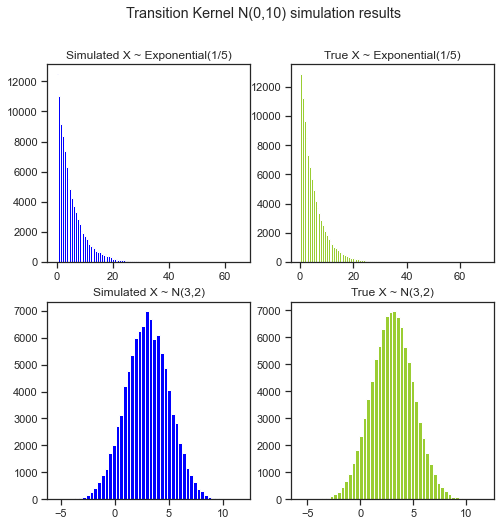

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

def mh(q, p, m, n):
    # randomize a number
    x = random.uniform(0.1, 1)
    for t in range(0, m+n):
        x_sample = q.sample(x)
        try:
            accept_prob = min(1, p.prob(x_sample)*q.prob(x_sample, x)/(p.prob(x)*q.prob(x, x_sample)))
        except:
            accept_prob = 0

        u = random.uniform(0, 1)

        if u < accept_prob:
            x = x_sample

        if t >= m:
            yield x

class Exponential(object):
    def __init__(self, scale):
        self.scale = scale
        self.lam = 1.0 / scale

    def prob(self, x):
        if x <= 0:
            raise Exception("The sample shouldn't be less than zero")

        result = self.lam * np.exp(-x * self.lam)
        return result

    def sample(self, num):
        sample = np.random.exponential(self.scale, num)
        return sample

# 假设我们的目标概率密度函数p1(x)是指数概率密度函数
scale = 5
p1 = Exponential(scale)


class Norm():
    def __init__(self, mean, std):
        self.mean = mean
        self.sigma = std

    def prob(self, x):
        return np.exp(-(x - self.mean) ** 2 / (2 * self.sigma ** 2.0)) * 1.0 / (np.sqrt(2 * np.pi) * self.sigma)

    def sample(self, num):
        sample = np.random.normal(self.mean, self.sigma, size=num)
        return sample

# 假设我们的目标概率密度函数p1(x)是均值标准差分别为3,2的正态分布
p2 = Norm(3, 2)

class Transition():
    def __init__(self, sigma):
        self.sigma = sigma

    def sample(self, cur_mean):
        cur_sample = np.random.normal(cur_mean, scale=self.sigma, size=1)[0]
        return cur_sample

    def prob(self, mean, x):
        return np.exp(-(x-mean)**2/(2*self.sigma**2.0)) * 1.0/(np.sqrt(2 * np.pi)*self.sigma)

# 假设我们的转移核标准差为10的正态分布
q = Transition(10)

m = 100
n = 100000 # 采样个数

simulate_samples_p1 = [li for li in mh(q, p1, m, n)]

plt.figure(figsize=(8, 8))

plt.subplot(2,2,1)
plt.hist(simulate_samples_p1, 100, color='blue')
plt.title("Simulated X ~ Exponential(1/5)")

samples = p1.sample(n)
plt.subplot(2,2,2)
plt.hist(samples, 100, color='yellowgreen')
plt.title("True X ~ Exponential(1/5)")

simulate_samples_p2 = [li for li in mh(q, p2, m, n)]
plt.subplot(2,2,3)
plt.hist(simulate_samples_p2, 50, color='blue')
plt.title("Simulated X ~ N(3,2)")

samples = p2.sample(n)
plt.subplot(2,2,4)
plt.hist(samples, 50, color='yellowgreen')
plt.title("True X ~ N(3,2)")

plt.suptitle("Transition Kernel N(0,10) simulation results")
plt.show()


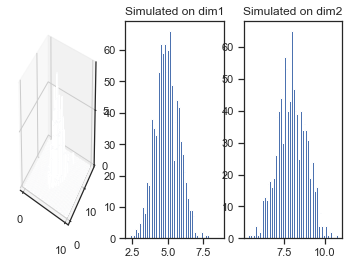

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


class Transition():
    def __init__(self, mean, cov):
        self.mean = mean
        self.sigmas = []
        for i in range(K):
            self.sigmas.append(np.sqrt(cov[i][i]))
        self.rho = cov[0][1]/(self.sigmas[0] * self.sigmas[1])

    def sample(self, id1, id2_list, x2_list):
        id2 = id2_list[0]  # only consider two dimension
        x2 = x2_list[0]  # only consider two dimension
        cur_mean = self.mean[id1] + self.rho*self.sigmas[id1]/self.sigmas[id2] * (x2-self.mean[id2])
        cur_sigma = (1-self.rho**2) * self.sigmas[id1]**2
        return np.random.normal(cur_mean, scale=cur_sigma, size=1)[0]


def gibbs(p, m, n):
    # randomize a number
    x = np.random.rand(K)
    for t in range(0, m+n):
        for j in range(K):
            total_indexes = list(range(K))
            total_indexes.remove(j)
            left_x = x[total_indexes]
            x[j] = p.sample(j, total_indexes, left_x)

        if t >= m:
            yield x


mean = [5, 8]
cov = [[1, 0.5], [0.5, 1]]
K = len(mean)
q = Transition(mean, cov)
m = 100
n = 1000

gib = gibbs(q, m, n)

simulated_samples = []

x_samples = []
y_samples = []
for li in gib:
    x_samples.append(li[0])
    y_samples.append(li[1])


fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')

hist, xedges, yedges = np.histogram2d(x_samples, y_samples, bins=100, range=[[0,10],[0,16]])
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

ax = fig.add_subplot(132)
ax.hist(x_samples, bins=50)
ax.set_title("Simulated on dim1")

ax = fig.add_subplot(133)
ax.hist(y_samples, bins=50)
ax.set_title("Simulated on dim2")
plt.show()

# 使用PyMC进行参数估计
原创 Marco Tompitak 引力天文 1周前

In [1]:
import numpy as np
import pymc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
np.random.seed(0) # For reproducibility

In [2]:
# We will use the same chirp function as previously
def chirp(t, tc, offset, A, dA, f, df):
    """
    Generate a chirp signal.    
    Arguments:
    t      -- array-like containing the times at which to evaluate the signal.
    tc     -- time of coalescence, after which the signal is terminated; 
              for times beyond tc the signal is set to the constant background.
    offset -- constant background term
    A      -- initial signal amplitude at t=0
    dA     -- linear coefficient describing the increase of the amplitude with time
    f      -- initial signal frequency at t=0
    df     -- linear coefficient describing the increase of the frequency with time
    """
    chirp = offset + (A + dA*t) * np.sin(2*np.pi*(f + df*t) * t)
    chirp[t>tc] = offset
    return chirp

# Let's choose some values for our injected signal
tc_true     = 75
offset_true = 30
A_true      = 6
dA_true     = 0.05
f_true      = 0.2
df_true     = 0.007

# Noise strength; keep it low here so we don't have to run sampling for too long
sigma = 50

# Time axis
t = np.linspace(0,100,10001)

# Injecting our signal into the noise
y_true = chirp(t, tc_true, offset_true, A_true, dA_true, f_true, df_true)
y_obs = np.random.normal(y_true, sigma)


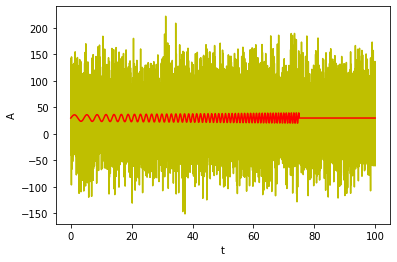

In [3]:
# Let's have a look
plt.plot(t, y_obs, color='y')
plt.plot(t, y_true, color='r');
plt.xlabel("t")
plt.ylabel("A")
plt.show()

# VIM 替换

In [ ]:
:%normal << 缩进移动到左侧
:%normal 2x 删除每行前两个字符
:%s/^  /    删除每行前两个字符，仅当它们是空格
:%s/^[0-9]\{1,\}//g 删除行首数字
:%s/^\s*//g    删除行首空格
:%s/\s*$//g    删除行尾空格
:g/^$/d        删除空格行
    
    

In [4]:
# Helper data to keep track of everything
parameters = ['tc', 'offset', 'A', 'dA', 'f', 'df']
bounds = {'tc':(0,100), 'offset':(0,100), 'A':(0,10), 'dA':(0,0.1), 'f':(0,1), 'df':(0,0.1)}

# Defining our parameters using pymc.Uniform()
offset = pymc.Uniform('offset', bounds['offset'][0], bounds['offset'][1], \
         value = bounds['offset'][0] + (bounds['offset'][1]-bounds['offset'][0])*np.random.random())

tc = pymc.Uniform('tc', bounds['tc'][0], bounds['tc'][1], \
     value = bounds['tc'][0] + (bounds['tc'][1]-bounds['tc'][0])*np.random.random())

A = pymc.Uniform('A', bounds['A'][0], bounds['A'][1], \
    value = bounds['A'][0] + (bounds['A'][1]-bounds['A'][0])*np.random.random())

dA = pymc.Uniform('dA', bounds['dA'][0], bounds['dA'][1], \
     value = bounds['dA'][0] + (bounds['dA'][1]-bounds['dA'][0])*np.random.random())

f = pymc.Uniform('f', bounds['f'][0], bounds['f'][1], \
    value = bounds['f'][0] +  (bounds['f'][1]-bounds['f'][0])*np.random.random())

df = pymc.Uniform('df', bounds['df'][0], bounds['df'][1], \
     value = bounds['df'][0] +  (bounds['df'][1]-bounds['df'][0])*np.random.random())


In [5]:
@pymc.deterministic
def y_model(t=t, tc=tc, offset=offset, A=A, dA=dA, f=f, df=df):
    return chirp(t, tc, offset, A, dA, f, df)

In [6]:
y = pymc.Normal('y', mu=y_model, tau=sigma**-2, observed=True, value=y_obs)
M = pymc.MCMC([y, tc, offset, A, dA, f, df, y_model])

M.sample(iter=100000, burn=50000, thin=1)

#Convert the results of our MCMC sampling
def mcmc_dataframe(M, skip_vars):
    names = []
    data = []
    for var in M.variables:
        try:
            name = var.trace.name
            if name not in skip_vars:
                names.append(var.trace.name)
                data.append(var.trace.gettrace().tolist())
        except AttributeError:
            pass
    df = pd.DataFrame(data).T
    df.columns = names
    return df

#Save as csv
mcmc_dataframe(M, ['y_model']).to_csv('samples.csv')

In [37]:
cp samples.csv pymc_sample_original.csv

In [38]:
pwd

'/Users/brettlv/blog/brettlv.github.io/pythoncode'

In [12]:
sns.pairplot?

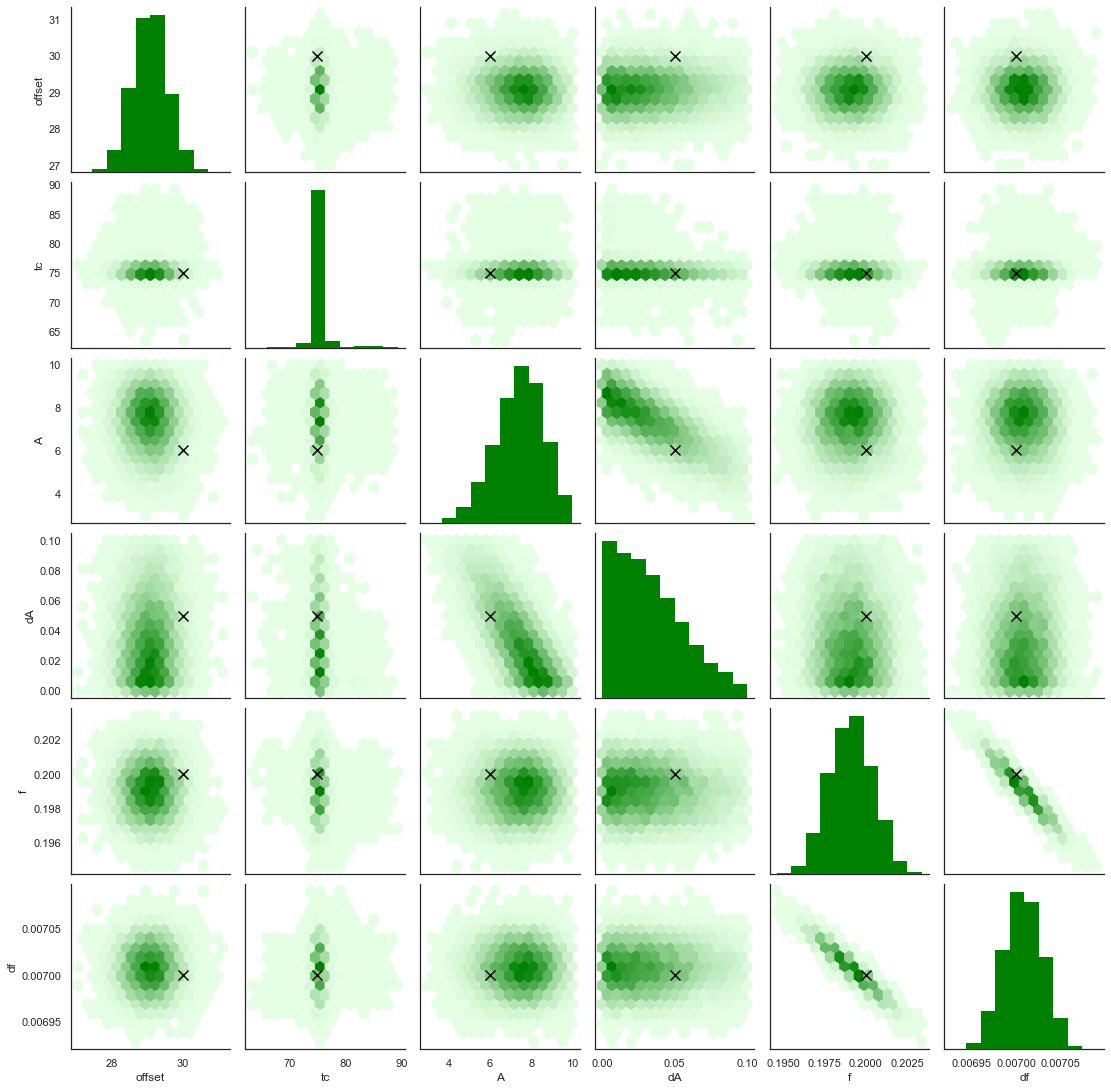

In [7]:
samples = pd.read_csv('samples.csv')

# Some settings for Seaborn
sns.set(style="ticks", color_codes=True)

# Wrapper function for the hexbin plotting style
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap = cmap, mincnt = 1)
    return

# Helper arrays
var_order = ['offset', 'tc', 'A', 'dA', 'f', 'df']
truth = [offset_true, tc_true, A_true, dA_true, f_true, df_true]
est = samples[var_order].max().values

# Plot a pairwise grid of scatter plots and histograms
with sns.axes_style("white"):
    g = sns.pairplot(
        samples[var_order],
        # We don't actually want the scatter plots, so we set
        # the marker size to 0
        plot_kws={"s": 0}, 
        diag_kws={"color":'green','lw': 0}
    )
    
    # Replace the scatter plots with hexbin plots
    g.map_offdiag(hexbin, color='green');


# Plot the injected values in the histograms
for i in range(len(var_order)):
    for j in range(len(var_order)):
        if i != j:
            ax = g.axes[i,j]
            ax.scatter([truth[j]], [truth[i]], color = "black", marker = 'x', s=100, linewidths=1.5)

引力波探测器面临的巨大挑战是信号要比噪声小几个数量级，但是由于可以根据广义相对论预测信号的形状，因此我们仍可以将信号从噪声中挖掘出来。

参数估计的实际情况比我们这里看过的例子要复杂得多，它们通常包含更多的噪声和更多的参数，这意味着要进行更高维度的采样，需要更高级的技术，例如嵌套采样。但是，我希望这个笔记至少给出了如何使用匹配滤波来探测引力波的想法。

# DisasterModel

https://pymc-devs.github.io/pymc/tutorial.html#an-example-statistical-model

In [28]:
# DisasterModel.py

"""
A model for coal mining disaster time series with a changepoint

switchpoint: s ~ U(0,111)
early_mean: e ~ Exp(1.)
late_mean: l ~ Exp(1.)
disasters: D[t] ~ Poisson(early if t <= s, l otherwise)
"""
__all__ = ['s','e','l','r','D']

from pymc import DiscreteUniform, Exponential, deterministic, Poisson, Uniform
import numpy as np

disasters_array =   np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                   3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                   2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                   1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                   0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                   3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

s = DiscreteUniform('s', lower=0, upper=110)
e = Exponential('e', beta=1)
l = Exponential('l', beta=1)

@deterministic(plot=False)
def r(s=s, e=e, l=l):
    """Concatenate Poisson means"""
    out = np.empty(len(disasters_array))
    out[:s] = e
    out[s:] = l
    return out

D = Poisson('D', mu=r, value=disasters_array, observed=True)

In [29]:
D

<pymc.distributions.new_dist_class.<locals>.new_class 'D' at 0x123f03e10>

In [6]:
disasters_array =   \
     np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                   3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                   2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                   1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                   0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                   3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [7]:
switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, doc='Switchpoint[year]')

In [8]:
early_mean = Exponential('early_mean', beta=1.)
late_mean = Exponential('late_mean', beta=1.)

In [9]:
@deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = np.empty(len(disasters_array))
    out[:s] = e
    out[s:] = l
    return out

In [10]:
disasters = Poisson('disasters', mu=rate, value=disasters_array, observed=True)

In [11]:
from pymc.examples import disaster_model
disaster_model.switchpoint.parents

{'lower': 0, 'upper': 110}

In [12]:
disaster_model.disasters.parents

{'mu': <pymc.PyMCObjects.Deterministic 'rate' at 0x121442400>}

In [13]:
disaster_model.rate.children

{<pymc.distributions.new_dist_class.<locals>.new_class 'disasters' at 0x121442780>}

In [14]:
disaster_model.disasters.value

array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3,
       1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1,
       1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1,
       1, 2, 4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1])

In [15]:
disaster_model.switchpoint.value

array(33)

In [16]:
disaster_model.rate.value

array([2.58951296, 2.58951296, 2.58951296, 2.58951296, 2.58951296,
       2.58951296, 2.58951296, 2.58951296, 2.58951296, 2.58951296,
       2.58951296, 2.58951296, 2.58951296, 2.58951296, 2.58951296,
       2.58951296, 2.58951296, 2.58951296, 2.58951296, 2.58951296,
       2.58951296, 2.58951296, 2.58951296, 2.58951296, 2.58951296,
       2.58951296, 2.58951296, 2.58951296, 2.58951296, 2.58951296,
       2.58951296, 2.58951296, 2.58951296, 0.4067309 , 0.4067309 ,
       0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 ,
       0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 ,
       0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 ,
       0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 ,
       0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 ,
       0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 ,
       0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 ,
       0.4067309 , 0.4067309 , 0.4067309 , 0.4067309 , 0.40673

In [17]:
from pymc.examples import disaster_model
from pymc import MCMC
M = MCMC(disaster_model)

In [18]:
M.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.7 sec

In [19]:
M.trace('switchpoint')[:]

array([35, 47, 34, 46, 46, 46, 46, 46, 37, 37, 37, 37, 37, 37, 37, 37, 37,
       37, 37, 37, 37, 37, 37, 46, 46, 35, 35, 35, 35, 35, 35, 35, 35, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 33,
       41, 41, 41, 41, 42, 41, 41, 41, 41, 46, 47, 46, 41, 41, 41, 36, 40,
       40, 37, 41, 41, 41, 41, 41, 41, 41, 40, 40, 40, 40, 40, 40, 40, 40,
       38, 41, 37, 43, 41, 38, 39, 39, 39, 39, 41, 41, 41, 41, 37, 47, 39,
       39, 39, 43, 36, 42, 42, 37, 37, 42, 42, 42, 42, 42, 41, 41, 41, 41,
       41, 41, 36, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 46,
       39, 39, 37, 39, 39, 39, 39, 39, 33, 43, 47, 36, 41, 41, 39, 46, 40,
       46, 40, 40, 38, 38, 39, 40, 41, 41, 41, 45, 39, 36, 39, 39, 39, 43,
       39, 39, 36, 42, 42

(array([  4.,  15.,  67., 152., 248., 191., 132.,  71.,  12.,   8.]),
 array([0.55790089, 0.63485675, 0.71181261, 0.78876846, 0.86572432,
        0.94268018, 1.01963604, 1.09659189, 1.17354775, 1.25050361,
        1.32745947]),
 <a list of 10 Patch objects>)

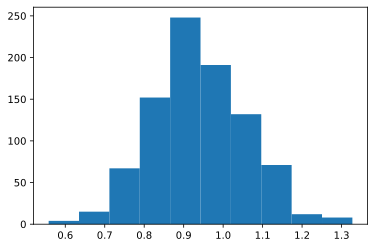

In [22]:
from pylab import hist, show
hist(M.trace('late_mean')[:])

Plotting late_mean
Plotting switchpoint
Plotting early_mean


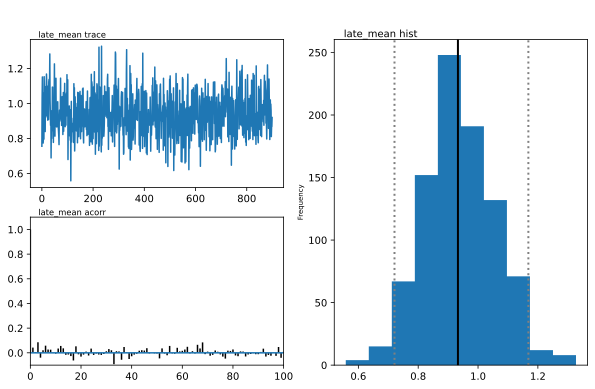

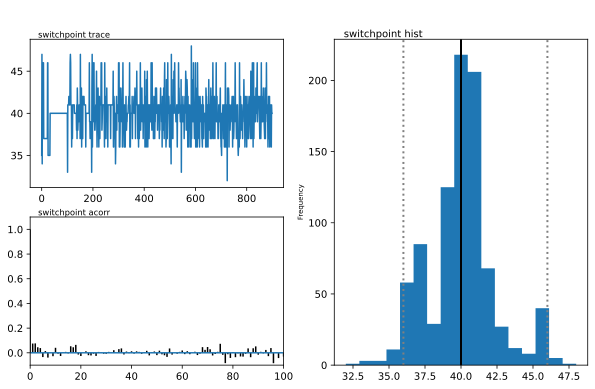

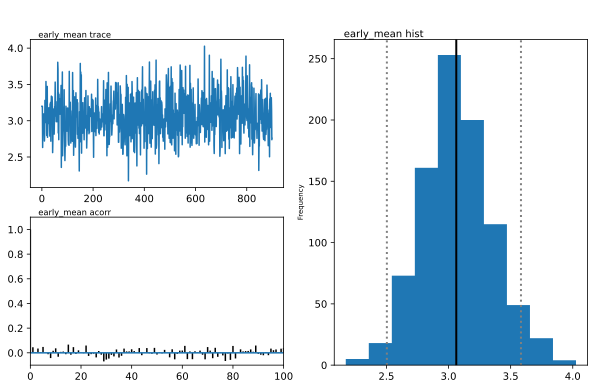

In [23]:
from pymc.Matplot import plot
plot(M)

In [24]:
x = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
2, 2, 3, 4, 2, 1, 3, None, 2, 1, 1, 1, 1, 3, 0, 0,
1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
3, 3, 1, None, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [25]:
masked_values = np.ma.masked_equal(x, value=None)

In [26]:
masked_values

masked_array(data=[4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3,
                   5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4,
                   2, 1, 3, --, 2, 1, 1, 1, 1, 3, 0, 0, 1, 0, 1, 1, 0, 0,
                   3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2,
                   1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, --, 2, 1, 1, 1, 1, 2,
                   4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
                   1, 0, 1],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False,  True,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
      

In [27]:
from pymc import Poisson
disasters = Poisson('disasters', mu=rate, value=masked_values, observed=True)